# Algorithmic Trading Model for "Buy Low Sell High" Using Python Take 3
### David Lowe
### April 21, 2020

SUMMARY: The purpose of this project is to construct an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: This algorithmic trading model uses daily close prices to generate trading signals. If the stock closes lower for the day, we will purchase at the opening of the next trading day if we did not have the stock on-hand. If the stock closes higher for the day, we will sell the stock at the opening of the next day if we have the stock on-hand. We will take no action if we encounter the trading signal to sell but have no stock on-hand or the trading signal to buy if we already have the stock on-hand.

We apply the analysis on a stock for a fixed period and compare its return/loss to a simple long-only model. The long-only model will purchase the stock at the opening of day one and hold the stock through the entire time.

In iteration Take1, we constructed and tested the trading model for the stock "GOOG" during the year of 2019.

In iteration Take2, we constructed and tested the trading model for the stock "GOOG" during the year of 2018.

In this Take3 iteration, we will modify the strategy by imposing a "waiting window" and test the trading model for the stock "GOOG" during the year of 2019. The waiting window will enforce one day of no action right after we buy or sell. We will observe whether the waiting window can improve our results over the previous strategy.

ANALYSIS: In iteration Take1 and during 2019, the "Buy Low Sell High" strategy returned 12.38%. In the meantime, the long-only approach achieved an accumulated return of 15.98%.

In iteration Take2 and during 2018, the "Buy Low Sell High" strategy returned -4.57%. In the meantime, the long-only approach achieved an accumulated return of -0.56%. The long-only method turned out to be a better choice again.

In this Take3 iteration and during 2019, the "Buy Low Sell High" strategy returned 13.54%. In the meantime, the long-only approach achieved an accumulated return of 15.98%. The long-only method turned out to be a better choice again. However, the waiting window did improve our buy-low-sell-high strategy as well.

CONCLUSION: For this period, the "Buy Low Sell High" strategy did not exceed the more straightforward long-only approach, so we should consider modeling more and different methods for this stock.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Various sources as illustrated below.

Dataset Reference: Various sources as documented below.

An algorithmic trading modeling project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Acquire and Pre-Process Data
3. Develop Strategy and Train Model
4. Backtest Model
5. Evaluate Performance

## Task 1. Prepare Environment

In [1]:
# Install the necessary Python module(s) in Colab
# !pip install yfinance edgar

In [2]:
# Create the random seed number for reproducible results
seedNum = 888

In [3]:
import os
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import json
import requests
from email.message import EmailMessage
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

/opt/conda/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [4]:
# Define the function for sending the status notification emails
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Algorithmic Trading Modeling Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [5]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose = False

# Set up the sendNotification flag to send progress emails (setting True will send emails!)
notifyStatus = False

# Configure the plotting style
plt.style.use('seaborn')

In [6]:
if notifyStatus: email_notify("Task 1. Prepare Environment has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [7]:
start_date = datetime(2019, 1, 1)
print("Starting date:", start_date)
# end_date = datetime.now()
end_date = datetime(2019, 12, 31)
print("Ending date:", end_date)

stock_symbol = 'GOOG'

initial_capital = 2000.00

Starting date: 2019-01-01 00:00:00
Ending date: 2019-12-31 00:00:00


In [8]:
if notifyStatus: email_notify("Task 1. Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2. Acquire and Pre-Process Data

In [9]:
if notifyStatus: email_notify("Task 2. Acquire and Pre-Process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Yahoo Finance

In [10]:
import yfinance as yf
yf.pdr_override()
stock_yahoo = pdr.get_data_yahoo(stock_symbol, start_date, end_date)
print(len(stock_yahoo), 'data points retrieved from the API call.')

[*********************100%***********************]  1 of 1 completed
251 data points retrieved from the API call.


In [11]:
stock_yahoo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2019-01-02 to 2019-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       251 non-null    float64
 1   High       251 non-null    float64
 2   Low        251 non-null    float64
 3   Close      251 non-null    float64
 4   Adj Close  251 non-null    float64
 5   Volume     251 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.7 KB


In [12]:
stock_yahoo.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,1016.570007,1052.319946,1015.710022,1045.849976,1045.849976,1532600
2019-01-03,1041.000000,1056.979980,1014.070007,1016.059998,1016.059998,1841100
2019-01-04,1032.589966,1070.839966,1027.417969,1070.709961,1070.709961,2093900
2019-01-07,1071.500000,1074.000000,1054.760010,1068.390015,1068.390015,1981900
2019-01-08,1076.109985,1084.560059,1060.530029,1076.280029,1076.280029,1764900


In [13]:
stock_yahoo.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-23,1355.869995,1359.800049,1346.510010,1348.839966,1348.839966,883100
2019-12-24,1348.500000,1350.260010,1342.780029,1343.560059,1343.560059,347500
2019-12-26,1346.170044,1361.327026,1344.469971,1360.400024,1360.400024,667500
2019-12-27,1362.989990,1364.530029,1349.310059,1351.890015,1351.890015,1038400
2019-12-30,1350.000000,1353.000000,1334.020020,1336.140015,1336.140015,1050900


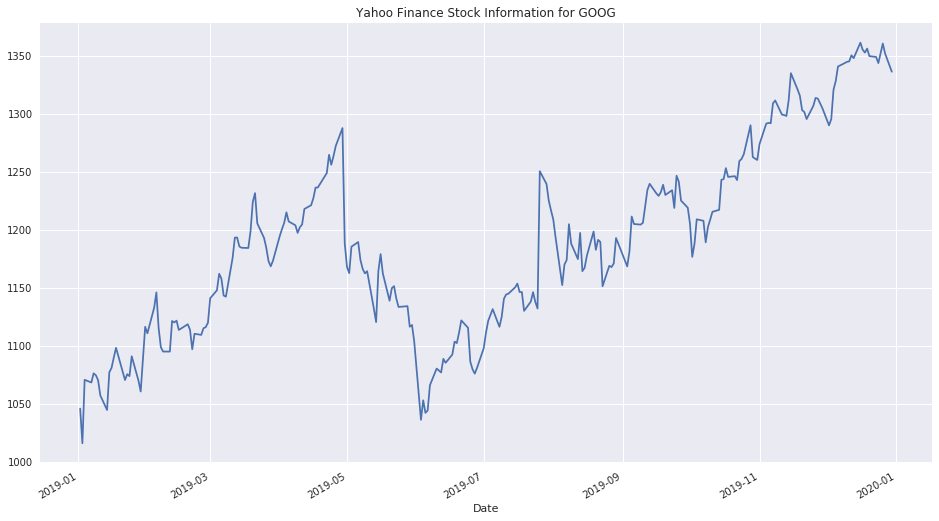

In [14]:
title_string = 'Yahoo Finance Stock Information for ' + stock_symbol
stock_yahoo['Adj Close'].plot(figsize=(16,9), title=title_string)
plt.show()

### 2.b) Alpha Vantage

In [15]:
# Check and see whether the API key is available
# alphavantage_key = os.environ.get('ALPHAVANTAGE_API')
# if (alphavantage_key==None): sys.exit("API key for Alpha Vantage not available. Script Processing Aborted!!!")
# alphavantage_url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=%s&outputsize=full&apikey=%s" % (stock_symbol, alphavantage_key)

In [16]:
# response = requests.get(alphavantage_url)
# alpha_dict = json.loads(response.text)
# print(len(alpha_dict['Time Series (Daily)']), 'data points retrieved from the API call.')
# if (verbose): print(alpha_dict)

In [17]:
# stock_alpha = pd.DataFrame(alpha_dict['Time Series (Daily)']).T
# stock_alpha.index = pd.to_datetime(stock_alpha.index)
# stock_alpha = stock_alpha.sort_index(ascending = True)
# stock_alpha.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume', 'dividend', 'split_coef']
# stock_alpha = stock_alpha.astype(float)
# stock_alpha.info()

In [18]:
# stock_alpha.head()

In [19]:
# stock_alpha.tail()

In [20]:
# title_string = alpha_dict['Meta Data']['1. Information'] + ' for ' + alpha_dict['Meta Data']['2. Symbol']
# stock_alpha['close'].plot(figsize=(16,9), title=title_string)
# plt.show()

### 2.c) IEX Cloud

In [21]:
# Check and see whether the API key is available
# iexcloud_key = os.environ.get('IEXCLOUD_API')
# if (iexcloud_key==None): sys.exit("API key for IEX Cloud not available. Script Processing Aborted!!!")
# iexcloud_url = "https://cloud.iexapis.com/stable/stock/%s/chart/5y?token=%s" % (stock_symbol, iexcloud_key)

In [22]:
# response = requests.get(iexcloud_url)
# iex_dict = json.loads(response.text)
# print(len(iex_dict), 'data points retrieved from the API call.')
# if (verbose): print(iex_dict)

In [23]:
# stock_iexcloud = pd.DataFrame(iex_dict)
# stock_iexcloud.set_index('date', inplace=True)
# stock_iexcloud = stock_iexcloud.sort_index(ascending = True)
# stock_iexcloud.info()

In [24]:
# stock_iexcloud.head()

In [25]:
# stock_iexcloud.tail()

In [26]:
# title_string = 'IEX Cloud Historical Stock Information for ' + stock_symbol
# stock_iexcloud['close'].plot(figsize=(16,9), title=title_string)
# plt.show()

### 2.d) Quandl

In [27]:
# Code not activated below as Quandl requires a premium subscription for EOD stock data
# Code maintained here for future testing and uses

In [28]:
# Check and see whether the API key is available
# quandl_key = os.environ.get('QUANDL_API')
# if (quandl_key==None): sys.exit("API key for Quandl not available. Script Processing Aborted!!!")
# quandl_url = "https://www.quandl.com/api/v3/datasets/EOD/%s.json?api_key=%s" % (stock_symbol, quandl_key)

In [29]:
# response = requests.get(quandl_url)
# quandl_dict = json.loads(response.text)
# print(len(quandl_dict['dataset']['data']), 'data points retrieved from the API call.')
# if (verbose): print(quandl_dict)

In [30]:
# stock_quandl = pd.DataFrame(quandl_dict['dataset']['data'])
# stock_quandl.columns = quandl_dict['dataset']['column_names']
# stock_quandl.set_index('Date', inplace=True)
# stock_quandl = stock_quandl.sort_index(ascending = True)
# stock_quandl.info()

In [31]:
# stock_quandl.head()

In [32]:
# stock_quandl.tail()

In [33]:
# title_string = 'Quandl EOD Stock Information for ' + quandl_dict['dataset']['dataset_code']
# stock_quandl['Close'].plot(figsize=(16,9), title=title_string)
# plt.show()

### 2.e) Federal Reserve Economic Data (FRED)

In [34]:
# Code maintained here for future uses. Update the data series name below before use

In [35]:
# fred_data = 'DGS10'
# fred_series = pdr.DataReader(fred_data, 'fred', start_date, end_date)
# print(len(fred_series), 'data points retrieved from the API call.')

In [36]:
# fred_series.head()

In [37]:
# fred_series.tail()

In [38]:
# title_string = '10-Year Treasury Constant Maturity Rate'
# fred_series.plot(figsize=(16,9), title=title_string)
# plt.show()

### 2.f) Electronic Data Gathering, Analysis, and Retrieval system (EDGAR)

In [39]:
# Code maintained here for future uses. Update the company name and CKI number below before use

In [40]:
# import edgar
# edgar_filing = edgar.Company("MICROSOFT CORP", "0000789019")
# tree = edgar_filing.get_all_filings(filing_type = "10-K")
# docs = edgar_filing.get_documents(tree, no_of_documents=5)
# print(len(docs), "documents retrieved from EDGAR.")

In [41]:
if notifyStatus: email_notify("Task 2. Acquire and Pre-Process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3. Develop Strategy and Train Model

In [42]:
if notifyStatus: email_notify("Task 3. Develop Strategy and Train Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Set up the Dataframe for the Trading Model

In [43]:
# Select the data source and pricing columns to use for modeling
trading_model = stock_yahoo.loc[:, ['Open', 'Adj Close']]
# trading_model = stock_alpha.loc[start_date:end_date, ['adj_close']]
# trading_model = stock_iexcloud.loc[start_date:end_date, ['close']]
# trading_model = stock_quandl.loc[start_date:end_date, ['Adj_Close']]

# Set up the standard column name for modeling
trading_model.rename(columns={'Open': 'open_price', 'Adj Close': 'close_price'}, inplace=True)
trading_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2019-01-02 to 2019-12-30
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open_price   251 non-null    float64
 1   close_price  251 non-null    float64
dtypes: float64(2)
memory usage: 5.9 KB


In [44]:
trading_model.head()

,open_price,close_price
Date,,
2019-01-02,1016.570007,1045.849976
2019-01-03,1041.000000,1016.059998
2019-01-04,1032.589966,1070.709961
2019-01-07,1071.500000,1068.390015
2019-01-08,1076.109985,1076.280029


In [45]:
trading_model.tail()

,open_price,close_price
Date,,
2019-12-23,1355.869995,1348.839966
2019-12-24,1348.500000,1343.560059
2019-12-26,1346.170044,1360.400024
2019-12-27,1362.989990,1351.890015
2019-12-30,1350.000000,1336.140015


### 3.b) Set up the Analysis Table with Indicators

In [46]:
# Generate the trading signals
trading_model['price_change'] = trading_model['close_price'].diff()
trading_model['price_lower'] = np.where(trading_model['price_change']<0, True, False)
trading_model['lower_previous_day'] = trading_model['price_lower'].shift(1)
# trading_model.dropna(inplace=True)

trading_model.head(20)

,open_price,close_price,price_change,price_lower,lower_previous_day
Date,,,,,
2019-01-02,1016.570007,1045.849976,NaN,False,NaN
2019-01-03,1041.000000,1016.059998,-29.789978,True,False
2019-01-04,1032.589966,1070.709961,54.649963,False,True
2019-01-07,1071.500000,1068.390015,-2.319946,True,False
2019-01-08,1076.109985,1076.280029,7.890015,False,True
2019-01-09,1081.650024,1074.660034,-1.619995,True,False
2019-01-10,1067.660034,1070.329956,-4.330078,True,True
2019-01-11,1063.180054,1057.189941,-13.140015,True,True
2019-01-14,1046.920044,1044.689941,-12.500000,True,True


In [47]:
trading_model.tail(20)

,open_price,close_price,price_change,price_lower,lower_previous_day
Date,,,,,
2019-12-02,1301.000000,1289.920044,-15.039917,True,True
2019-12-03,1279.569946,1295.280029,5.359985,False,True
2019-12-04,1307.010010,1320.540039,25.260010,False,False
2019-12-05,1328.000000,1328.130005,7.589966,False,False
2019-12-06,1333.439941,1340.619995,12.489990,False,False
2019-12-09,1338.040039,1343.560059,2.940063,False,False
2019-12-10,1341.500000,1344.660034,1.099976,False,False
2019-12-11,1350.839966,1345.020020,0.359985,False,False
2019-12-12,1345.939941,1350.270020,5.250000,False,False


In [48]:
if notifyStatus: email_notify("Task 3. Develop Strategy and Train Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4. Backtest Model

We create a portfolio data frame to track the daily activities of our trading strategy.

The definition of the columns are as follow:

trade_action: 1 - Buy, -1 - Sell, 0 - No Action
qty_onhand: quantity of position on-hand at the end of day
cost_basis: If buying, the cost of the transaction
sold_transaction: If selling, the proceeds from the transaction
cash_onhand: Cash on-hand at the end of day
position_value: The value of the position at the end of day
total_position: Value of the portfolio, cash plus security
accumu_return: Accumulated return or loss compared to the initial capital investment

In [49]:
if notifyStatus: email_notify("Task 4. Backtest Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [50]:
# Construct a portfolio to track the transactions and returns
portfolio = pd.DataFrame(index=trading_model.index, columns=['trade_action', 'qty_onhand', 'cost_basis', 'sold_transaction',
                                                             'gain_loss', 'cash_onhand', 'position_value', 'total_position', 'accumu_return'])
portfolio.iloc[0]['trade_action'] = 0
portfolio.iloc[0]['qty_onhand'] = 0
portfolio.iloc[0]['cost_basis'] = 0.00
portfolio.iloc[0]['sold_transaction'] = 0.00
portfolio.iloc[0]['gain_loss'] = 0.00
portfolio.iloc[0]['cash_onhand'] = initial_capital
portfolio.iloc[0]['position_value'] = 0.00
portfolio.iloc[0]['total_position'] = initial_capital
portfolio.iloc[0]['accumu_return'] = portfolio.iloc[0]['total_position'] - initial_capital
recent_acq_index = -1
recent_sold_index = -1

# The conditional parameters below determine how the trading strategy will be carried out
for i in range(1, len(portfolio)):
    if (trading_model.iloc[i]['lower_previous_day'] and (portfolio.iloc[i-1]['qty_onhand'] == 0) and
       (i - recent_sold_index) >= 2):
        portfolio.iloc[i]['trade_action'] = 1
        portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
        portfolio.iloc[i]['cost_basis'] = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
        portfolio.iloc[i]['sold_transaction'] = 0.00
        portfolio.iloc[i]['gain_loss'] = 0.00
        portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] - portfolio.iloc[i]['cost_basis']
        recent_cost = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
        recent_acq_index = i
    elif ((not trading_model.iloc[i]['lower_previous_day']) and (portfolio.iloc[i-1]['qty_onhand'] > 0) 
          and (i - recent_acq_index) >= 2) :
        portfolio.iloc[i]['trade_action'] = -1
        portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
        portfolio.iloc[i]['cost_basis'] = 0.00
        portfolio.iloc[i]['sold_transaction'] = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'] * -1
        portfolio.iloc[i]['gain_loss'] = (recent_cost + (trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'])) * -1
        portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] + portfolio.iloc[i]['sold_transaction']
        recent_cost = 0.00
        recent_sold_index = i
    else:
        portfolio.iloc[i]['trade_action'] = 0
        portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand']
        portfolio.iloc[i]['cost_basis'] = portfolio.iloc[i-1]['cost_basis']
        portfolio.iloc[i]['sold_transaction'] = 0.00
        portfolio.iloc[i]['gain_loss'] = 0.00
        portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand']
    portfolio.iloc[i]['position_value'] = trading_model.iloc[i]['close_price'] * portfolio.iloc[i]['qty_onhand']
    portfolio.iloc[i]['total_position'] = portfolio.iloc[i]['cash_onhand'] + portfolio.iloc[i]['position_value']
    portfolio.iloc[i]['accumu_return'] = portfolio.iloc[i]['total_position'] - initial_capital

portfolio.head(20)

,trade_action,qty_onhand,cost_basis,sold_transaction,gain_loss,cash_onhand,position_value,total_position,accumu_return
Date,,,,,,,,,
2019-01-02,0,0,0,0,0,2000,0,2000,0
2019-01-03,0,0,0,0,0,2000,0,2000,0
2019-01-04,1,1,1032.59,0,0,967.41,1070.71,2038.12,38.12
2019-01-07,0,1,1032.59,0,0,967.41,1068.39,2035.8,35.8
2019-01-08,0,1,1032.59,0,0,967.41,1076.28,2043.69,43.6901
2019-01-09,-1,0,0,1081.65,49.0601,2049.06,0,2049.06,49.0601
2019-01-10,0,0,0,0,0,2049.06,0,2049.06,49.0601
2019-01-11,1,1,1063.18,0,0,985.88,1057.19,2043.07,43.0699
2019-01-14,0,1,1063.18,0,0,985.88,1044.69,2030.57,30.5699


In [51]:
portfolio.tail(20)

,trade_action,qty_onhand,cost_basis,sold_transaction,gain_loss,cash_onhand,position_value,total_position,accumu_return
Date,,,,,,,,,
2019-12-02,0,1,1307.12,0,0,942.54,1289.92,2232.46,232.46
2019-12-03,0,1,1307.12,0,0,942.54,1295.28,2237.82,237.82
2019-12-04,-1,0,0,1307.01,-0.109985,2249.55,0,2249.55,249.55
2019-12-05,0,0,0,0,0,2249.55,0,2249.55,249.55
2019-12-06,0,0,0,0,0,2249.55,0,2249.55,249.55
2019-12-09,0,0,0,0,0,2249.55,0,2249.55,249.55
2019-12-10,0,0,0,0,0,2249.55,0,2249.55,249.55
2019-12-11,0,0,0,0,0,2249.55,0,2249.55,249.55
2019-12-12,0,0,0,0,0,2249.55,0,2249.55,249.55


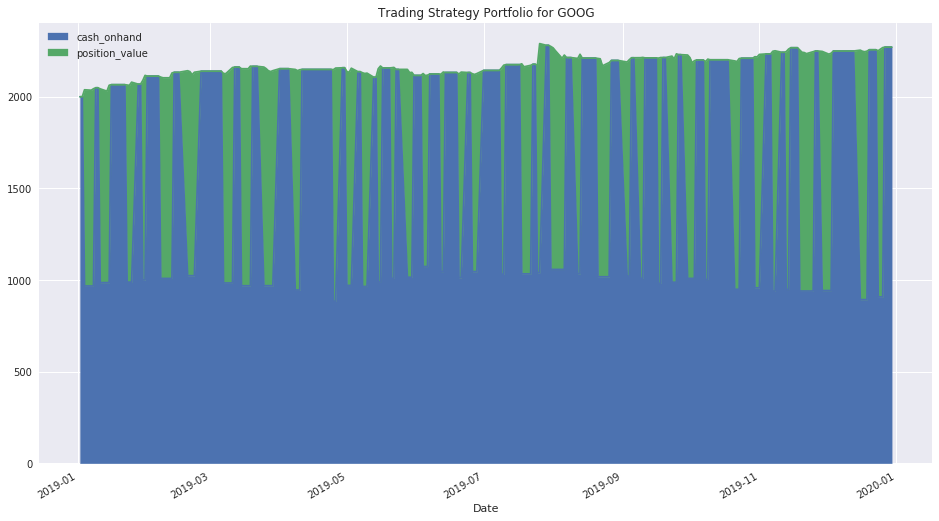

In [52]:
title_string = 'Trading Strategy Portfolio for ' + stock_symbol
portfolio[['cash_onhand','position_value']].plot.area(figsize=(16,9), stacked=True)
plt.title(title_string)
plt.show()

In [53]:
if notifyStatus: email_notify("Task 4. Backtest Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5. Evaluate Performance

We compare the performance of our trading strategy with the benchmark methodology that we have chosen.

In [54]:
if notifyStatus: email_notify("Task 5. Evaluate Performance has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [55]:
# Construct a long only as a benchmark for the trading strategy
benchmark = pd.DataFrame(index=trading_model.index, columns=['trade_action', 'qty_onhand', 'cash_onhand', 'position_value', 'total_position', "accumu_return"])
benchmark.iloc[0]['trade_action'] = 1
benchmark.iloc[0]['qty_onhand'] = benchmark.iloc[0]['trade_action']
benchmark.iloc[0]['cash_onhand'] = initial_capital - (trading_model.iloc[0]['open_price'] * benchmark.iloc[0]['trade_action'])
benchmark.iloc[0]['position_value'] = trading_model.iloc[0]['open_price']
benchmark.iloc[0]['total_position'] = initial_capital
benchmark.iloc[0]['accumu_return'] = benchmark.iloc[0]['total_position'] - initial_capital

for i in range(1, len(portfolio)):
    benchmark.iloc[i]['trade_action'] = 0
    benchmark.iloc[i]['qty_onhand'] = benchmark.iloc[i-1]['qty_onhand']
    benchmark.iloc[i]['cash_onhand'] = benchmark.iloc[i-1]['cash_onhand']
    benchmark.iloc[i]['position_value'] = trading_model.iloc[i]['close_price'] * benchmark.iloc[i]['qty_onhand']
    benchmark.iloc[i]['total_position'] = benchmark.iloc[i]['cash_onhand'] + benchmark.iloc[i]['position_value']
    benchmark.iloc[i]['accumu_return'] = benchmark.iloc[i]['total_position'] - initial_capital

benchmark.head(10)

,trade_action,qty_onhand,cash_onhand,position_value,total_position,accumu_return
Date,,,,,,
2019-01-02,1,1,983.43,1016.57,2000,0
2019-01-03,0,1,983.43,1016.06,1999.49,-0.51001
2019-01-04,0,1,983.43,1070.71,2054.14,54.14
2019-01-07,0,1,983.43,1068.39,2051.82,51.82
2019-01-08,0,1,983.43,1076.28,2059.71,59.71
2019-01-09,0,1,983.43,1074.66,2058.09,58.09
2019-01-10,0,1,983.43,1070.33,2053.76,53.7599
2019-01-11,0,1,983.43,1057.19,2040.62,40.6199
2019-01-14,0,1,983.43,1044.69,2028.12,28.1199


In [56]:
benchmark.tail(10)

,trade_action,qty_onhand,cash_onhand,position_value,total_position,accumu_return
Date,,,,,,
2019-12-16,0,1,983.43,1361.17,2344.6,344.6
2019-12-17,0,1,983.43,1355.12,2338.55,338.55
2019-12-18,0,1,983.43,1352.62,2336.05,336.05
2019-12-19,0,1,983.43,1356.04,2339.47,339.47
2019-12-20,0,1,983.43,1349.59,2333.02,333.02
2019-12-23,0,1,983.43,1348.84,2332.27,332.27
2019-12-24,0,1,983.43,1343.56,2326.99,326.99
2019-12-26,0,1,983.43,1360.4,2343.83,343.83
2019-12-27,0,1,983.43,1351.89,2335.32,335.32


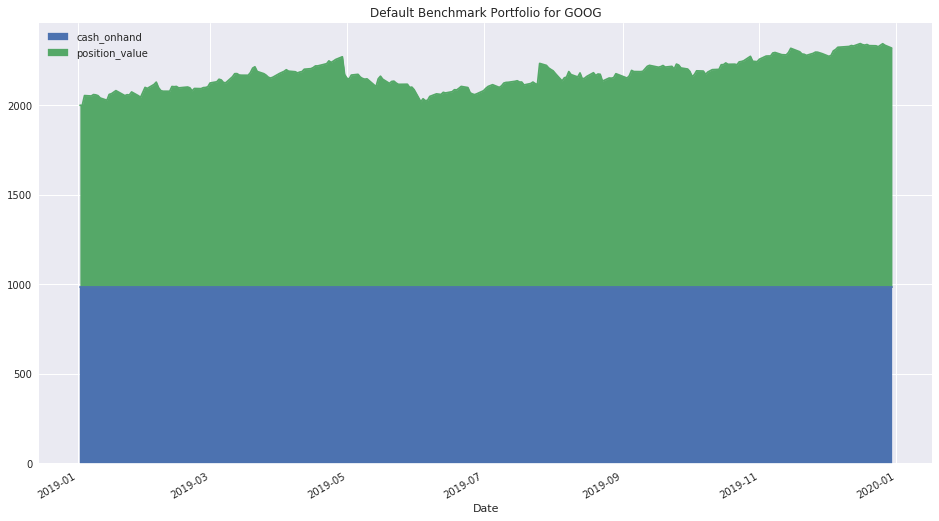

In [57]:
title_string = 'Default Benchmark Portfolio for ' + stock_symbol
benchmark[['cash_onhand','position_value']].plot.area(figsize=(16,9), stacked=True)
plt.title(title_string)
plt.show()

In [58]:
# Build a performance data frame to display the returns from the strategy and benchmark
performance = pd.DataFrame(index=trading_model.index)
performance['strategy'] = portfolio['accumu_return']
performance['benchmark'] = benchmark['accumu_return']

performance.head(10)

,strategy,benchmark
Date,,
2019-01-02,0,0
2019-01-03,0,-0.51001
2019-01-04,38.12,54.14
2019-01-07,35.8,51.82
2019-01-08,43.6901,59.71
2019-01-09,49.0601,58.09
2019-01-10,49.0601,53.7599
2019-01-11,43.0699,40.6199
2019-01-14,30.5699,28.1199


In [59]:
print('The accumulated return/loss from the trading strategy: %.2f percent' % (performance.iloc[-1]['strategy'] / initial_capital * 100))
print('The accumulated return/loss from the long-only benchmark: %.2f percent' % (performance.iloc[-1]['benchmark'] / initial_capital * 100))

The accumulated return/loss from the trading strategy: 13.54 percent
The accumulated return/loss from the long-only benchmark: 15.98 percent


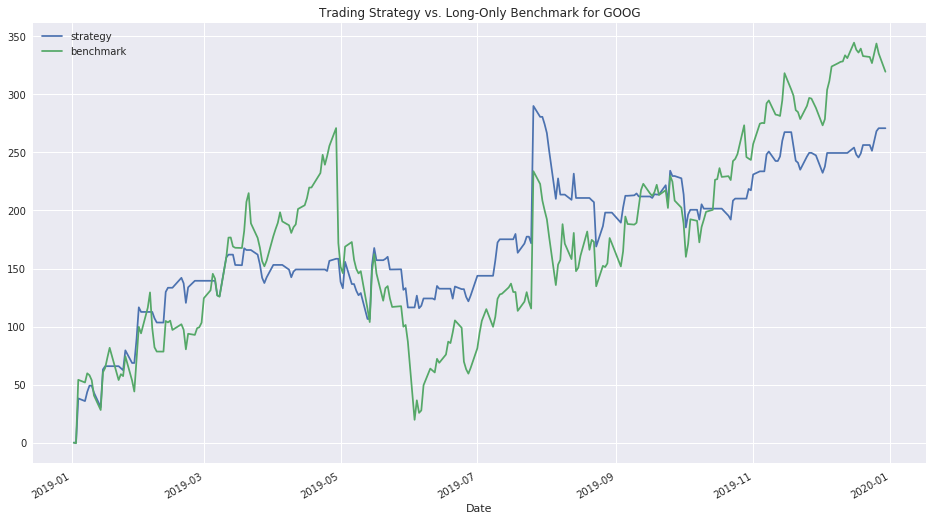

In [60]:
title_string = 'Trading Strategy vs. Long-Only Benchmark for ' + stock_symbol
performance[['strategy','benchmark']].plot(figsize=(16,9), title=title_string)
plt.show()

In [61]:
if notifyStatus: email_notify("Task 5. Evaluate Performance completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [62]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:00:11.649729
